# 確率ロボティクス 2021年度 課題
拡張カルマンフィルタを用いた自己位置推定のアルゴリズムをシミュレーションする．
ランドマークはどの位置，向きからでも観測できるものとする．
たまによくわからない位置を推定しちゃうのはよくわからない．

In [1]:
# インポート
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
class Robot:
    def __init__(self, x, y, th):
        self.dt = 0.01
        self.xt = np.array([x, y, th])
        self.actual_xt = np.array([x, y, th])
        
    def updateRobotPos(self, v, w): 
        theta = self.xt[2]
        dxt = np.array([-v / w * math.sin(theta) + v / w * math.sin(theta + w * self.dt), v/w*math.cos(theta)-v/w*math.cos(theta+w*self.dt), w*self.dt])
        self.xt = self.xt + dxt

        vn = v + np.random.normal(loc=0, scale=1.5)
        wn = w + np.random.normal(loc=0, scale=1.5)
        actual_theta = self.actual_xt[2]
        actual_dxt = np.array([-vn / wn * math.sin(actual_theta) + vn / wn * math.sin(actual_theta + wn * self.dt), vn/wn*math.cos(actual_theta)-vn/wn*math.cos(actual_theta+wn*self.dt), wn*self.dt])
        self.actual_xt = self.actual_xt + actual_dxt

In [3]:
def plot(robot, actual_robot, estimate_robot, m):
    fig = plt.figure(figsize=(10, 10))
    world = fig.add_subplot(1,1,1)
    world.set_xlim(-1.0,1.0)
    world.set_ylim(-0.5,1.5)

    plt.scatter(m[0], m[1], s=100, marker="*", color="blue")
    
    x = []
    y = []
    u = []
    v = []
    for r in robot:
        x.append(r[0][0])
        y.append(r[0][1])
        u.append(math.cos(r[0][2]))
        v.append(math.sin(r[0][2]))
        
    plt.quiver(x, y, u, v, color="gray", alpha = 0.2)
    
    x = []
    y = []
    u = []
    v = []
    for r in actual_robot:
        x.append(r[0][0])
        y.append(r[0][1])
        u.append(math.cos(r[0][2]))
        v.append(math.sin(r[0][2]))
        
    plt.quiver(x, y, u, v, color="green", alpha = 0.5)
    
    x = []
    y = []
    u = []
    v = []
    for r in estimate_robot:
        x.append(r[0][0])
        y.append(r[1][0])
        u.append(math.cos(r[2][0]))
        v.append(math.sin(r[2][0]))
        
    plt.quiver(x, y, u, v, color="red", alpha = 1.0)

    plt.legend(["Landmark", "Ideal Robot", "Actual Robot", "Estimated Robot"])
    plt.show()

In [4]:
def ekf(pre_estimate, sigma_t1, ut, z, m):
    dt = 0.01
    alpha = np.array([0.001, 0.001, 0.001, 0.001])
    sigma_r = 0.01
    sigma_phai = 0.5
    sigma_s = 0.1
    
    th = pre_estimate[2];
    v = ut[0];
    w = ut[1];
    
    Gm = np.array([[1, 0, (-v/w)*math.cos(th) + (v/w)*math.cos(th+w*dt)], [0, 1, (-v/w)*math.sin(th) + (v/w)*math.sin(th+w*dt)], [0, 0, 1]])
    Vm = np.array([[(-math.sin(th)+math.sin(th+w*dt))/w,  v*(math.sin(th)-math.sin(th+w*dt))/(w^2)+v*math.cos(th+w*dt)*dt/w],
          [(math.cos(th)-math.cos(th+w*dt))/w, -v*(math.cos(th)-math.cos(th+w*dt))/(w^2)+v*math.sin(th+w*dt)*dt/w],
          [0, dt]])
    Mm = np.array([[alpha[0] * v**2 + alpha[1] * w**2, 0],
          [0, alpha[2] * v**2 + alpha[3] * w**2]])
    estimate_b = pre_estimate + np.array([[(-v/w)*math.sin(th) + (v/w)*math.sin(th+w*dt)], [(v/w)*math.cos(th) - (v/w)*math.cos(th+w*dt)], [w*dt]])
    sigma_tb = Gm.dot(sigma_t1).dot(Gm.T) + Vm.dot(Mm).dot(Vm.T)
    Qm = np.array([[sigma_r**2, 0, 0], [0, sigma_phai**2, 0], [0, 0, sigma_s**2]])
    
    q = (m[0]-estimate_b[0][0])**2 + (m[1]-estimate_b[1][0])**2
    zh = np.array([[math.sqrt(q)], [math.atan2(m[1]-estimate_b[1][0], m[0]-estimate_b[0][0]) - estimate_b[2][0]], [0]])
    Hm = np.array([[-(m[0] - estimate_b[0][0]) / math.sqrt(q), -(m[1] - estimate_b[1][0]) / math.sqrt(q), 0], [(m[1] - estimate_b[1][0]) / q, -(m[0] - estimate_b[0][0]) / q, -1], [0, 0, 0]])
    Sm = Hm.dot(sigma_tb).dot(Hm.T) + Qm
    Km = sigma_tb.dot(Hm.T).dot(np.linalg.inv(Sm))
    estimate_b = estimate_b + Km.dot((z - zh))
    sigma_tb = (np.eye(3) - Km.dot(Hm)).dot(sigma_tb) 

    estimate = estimate_b
    sigma_t = sigma_tb
    
    return estimate, sigma_t

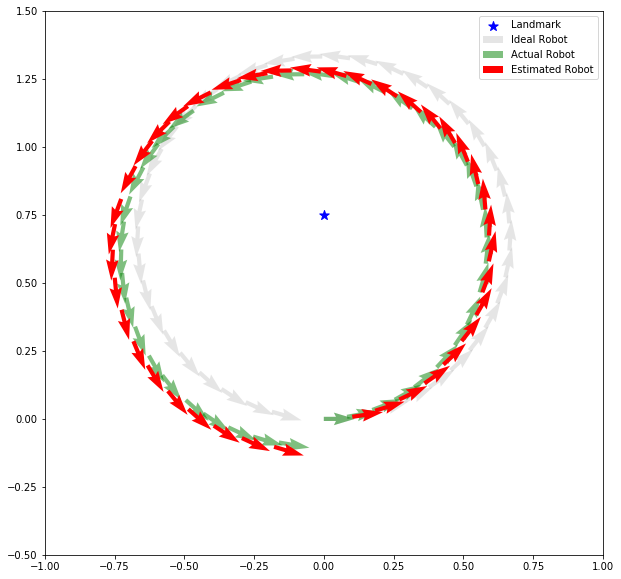

In [5]:
robot = Robot(0, 0, 0)
store_robot = [np.array([robot.xt])]
store_actual_robot = [np.array([robot.actual_xt])]
store_estimate_robot = []
m = np.array([0, 0.75])

estimate = np.array([[robot.xt[0]], [robot.xt[1]], [robot.xt[2]]])
sigma_t = np.array([[0.001**2,0,0], [0,0.001**2,0],[0,0,0.01**2]])


pre_estimate = estimate
sigma_t1 = sigma_t
u = np.array([10, 15])

for i in range(0, 40):
    #### 移動 ####
    robot.updateRobotPos(u[0], u[1])
    store_robot.append(np.array([robot.xt]))
    store_actual_robot.append(np.array([robot.actual_xt]))
    
    #### 観測 ####
    z = m - np.array([robot.actual_xt[0], robot.actual_xt[1]])
    zt = np.array([[math.sqrt(z[0]**2+z[1]**2)], [math.atan2(z[1], z[0] - robot.actual_xt[2])], [0]])
    
    #### カルマンフィルタ #####
    pre_estimate = estimate
    sigma_t1 = sigma_t
    estimate, sigma_t = ekf(pre_estimate, sigma_t1, u, zt, m)
    store_estimate_robot.append(estimate)
    
plot(store_robot, store_actual_robot, store_estimate_robot, m)